# Quantum Computing Basics

**Prerequisites:** Linear Algebra, Quantum Mechanics and Python

In [32]:
from functools import partial
import warnings

warnings.filterwarnings("ignore")

import tensorcircuit as tc
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

tc.set_dtype("complex128")
K = tc.set_backend("jax")

## Qubits

**Superposition**: In classical computation, the unit of information is a bit, which can be 0 or 1. In quantum computation, this unit is a quantum bit (qubit), which is a superposition of 0 and 1 ($|0\rangle$ and $|1\rangle$ in Dirac notation). We identify the two basis states with the vectors $\binom{1}{0}$ and $\binom{0}{1}$, respectively. A single qubit can be in any superposition

$$
\alpha_0|0\rangle+\alpha_1|1\rangle=\binom{\alpha_0}{\alpha_1},
$$

with $\left|\alpha_0\right|^2+\left|\alpha_1\right|^2=1.$

**Multiple-qubit system**: Similarly we can think of systems of more than 1 qubit, which "live" in the tensor product space of multiple-qubit systems. For instance, a 2-qubit system has 4 basis states: $|0\rangle \otimes|0\rangle,|0\rangle \otimes|1\rangle,|1\rangle \otimes|0\rangle,|1\rangle \otimes|1\rangle$. Here for instance $|1\rangle \otimes|0\rangle$ means that the first qubit is in its basis state $|1\rangle$ and the second qubit is in its basis state $|0\rangle$. We will often abbreviate this to $|1\rangle|0\rangle$,or $|10\rangle $, which is equivalent 

$$
|10\rangle = \binom{0}{1}\otimes\binom{1}{0} = \begin{pmatrix} 0\\ 0\\ 1\\ 0\end{pmatrix}
$$

in vector space. 

More generally, a register of $n$ qubits has $N=2^n$ basis states, each of the form $\left|b_1 b_2 \cdots b_n\right\rangle$, with $b_i \in\{0,1\}$. We often abbreviate $0 \cdots 0$ to $0^n$. Since bitstrings of length $n$ can be viewed as numbers between 0 and $2^n-1$, we can also write the basis states as numbers $|0\rangle,|1\rangle,|2\rangle, \cdots,\left|2^n-1\right\rangle$. A quantum state of $n$ qubits can be in any superposition

$$
\vert \psi\rangle=\sum_{j=0}^{2^n-1}\alpha_j|j\rangle
$$

with $ \sum_{j=0}^{2^n-1}\left|\alpha_j\right|^2=1$. The adjoint bra state for the ket state is defined as  $\langle \psi \vert = \sum_{j=0}^{2^n-1}\alpha_j^*\langle j\vert$.


If we measure $\vert \psi\rangle$ in the computational basis, we obtain the $n$-bit state state $|j\rangle$ with probability $\left|\alpha_j\right|^2$

**Overlap**: The overlap between two quantum states in  $n$-qubit space ($N=2^n$) is expressed as follows in Dirac notation and explicit vectors:

$$
\langle \psi\vert \phi\rangle = \begin{pmatrix}\psi_0^*, \psi_1^*, \cdots \psi_{N-1}^*\end{pmatrix}\begin{pmatrix} \phi_0\\ \phi_1 \\ \cdots\\ \phi_{N-1}\end{pmatrix}=\sum_{i=0}^{2^n-1} \psi_i^*\phi_i.
$$

The overlap between two states living on $n$-qubit and $m$-qubit ($n>m$) Hilbert space is a (unnormalized) state living in $n-m$ qubit Hilbert space.

$$
\langle \psi\vert_n \vert \phi\rangle_m = \sum_{i=0}^{2^m}\sum_{j=0}^{2^{n-m}}\sum_{k=0}^{2^m}\psi^*_{ij}\langle i\vert_{m}\langle j\vert_{n-m} \phi_k \vert k\rangle_m
= \sum_{i=0}^{2^m}\sum_{j=0}^{2^{n-m}} \psi_{ij}^* \phi_i \langle j\vert_{n-m}.
$$

*Excercise:* Quantum basis state $\vert 5\rangle$ for 4-qubit system.

In [2]:
s = f"{5:04b}"
print(f"basis state |{s}>")
v1 = np.array([0, 1.0])
v0 = np.array([1, 0.0])
v_list = [v0, v1]


def tensor_product(*vs):
    if len(vs) > 2:
        return np.kron(vs[0], tensor_product(*vs[1:]))
    elif len(vs) == 2:
        return np.kron(vs[0], vs[1])
    else:
        raise ValueError("The number of vectors is not allowed")


print(f"the state in vector form is {tensor_product(*[v_list[int(i)] for i in s])}")

# the nonzero element is exactly the 5-th (0-indexed)

basis state |0101>
the state in vector form is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


**Reduced density matrix**: The subsystem of a pure quantum state is represented by the reduced density matrix, which is obtained by partial tracing the complement subsystems. For a pure state $\vert \psi\rangle $ defined on $n+m$ qubits, the reduced density matrix $\rho$ on the first $n$ qubits is

$$
\rho = \rm{Tr}_m(\vert\psi\rangle_{n+m} \langle \psi\vert_{n+m}) = \sum_{i=0}^{2^m-1} \langle i\vert_m \vert\psi\rangle_{n+m} \langle \psi\vert_{n+m} \vert i\rangle_m.
$$

**Entanglement**: The entanglement entropy of a subsystem with the complementary subsystem is defined as the von Neumann entropy of the corresponding reduced density matrix $S=-\rm{Tr}(\rho \ln \rho)$.

*Excercise:* The average half-chain entanglement entropy of a random state.

In [3]:
def halfchain_ee(s, L):
    return tc.quantum.entanglement_entropy(s, [i for i in range(L // 2)])


halfchain_ee_batch = K.vmap(halfchain_ee, vectorized_argnums=0)

L = 10
batch = 1024
batch_s = np.random.normal(size=[batch, 2**L]) + 1.0j * np.random.normal(
    size=[batch, 2**L]
)
batch_s /= np.linalg.norm(batch_s, axis=0)

print(np.mean(halfchain_ee_batch(batch_s, L)))
print(L / 2 * np.log(2) - 1 / 2)  # Page value

2.9665263540343343
2.9657359027997265


## Quantum gates

A unitary that acts on several qubits is called a quantum gate, in analogy to classical logic gates like AND, OR, NOT.


**Single-qubit gates**:

Some typical single-qubit gates (2*2 unitary matrix).

1. $X$: the bitflip gate which negates the bit, i.e., $X\vert 0\rangle = \vert 1\rangle, X\vert 1\rangle = \vert 0 \rangle$,

$$
X=\begin{pmatrix}
0 & 1\\
1&0
\end{pmatrix}
.
$$

2. $Z$: the phaseflip gate which puts a $−$ in front of $\vert 1\rangle$,

$$
Z=\begin{pmatrix}
1 & 0\\
0& -1
\end{pmatrix}
.
$$

3. $Y$: $Y=iXZ$ which applies both bitflip and phaseflip on the qubit,

$$
Y=\begin{pmatrix}
0 & -i\\
i& 0
\end{pmatrix}
.
$$

4. $H$: Hadamard gate, which is a single-qubit analogy for Fourier transformation, i.e. $H\vert 0\rangle = \frac{1}{\sqrt{2}}(\vert 0\rangle +\vert 1\rangle)$, $H\vert 1\rangle = \frac{1}{\sqrt{2}}(\vert 0\rangle -\vert 1\rangle)$, with the matrix form

$$
H=\frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1\\
1& -1
\end{pmatrix}
.
$$ 


5. $R_\phi $: single qubit phase rotation gate, i.e. $R_\phi \vert 0\rangle = \vert 0\rangle, R_\phi\vert 1\rangle = e^{i\phi}\vert 1\rangle$,

$$
R_\phi=\begin{pmatrix}
1 & 0\\
0& e^{i\phi}
\end{pmatrix}
.
$$ 

Note that $Z=R_\pi$ and $T=R_{\pi/4}$.

Also note that both quantum gates and quantum states have an overall phase redundency with no physical information. Namely, $\vert 00\rangle + \vert 11\rangle$ and $-\vert 00\rangle -\vert 11\rangle$ are the same states, and $R_\phi$ gate can also be expressed as:

$$
R_\phi=\begin{pmatrix}
e^{-i\phi/2} & 0\\
0& e^{i\phi/2}
\end{pmatrix}
.
$$ 

6. Rx, Ry, Rz gate: in general we have the parameterized rotation gate as $R_P(\theta)=e^{i\theta/2 P}$, where $P$ corresponds the Pauli matrices $X, Y, Z$.

**Inverse gate**:

If $UU^{-1}=I$, we call the unitary $U^{-1}$ the inverse gate of $U$, e.g. $X^{-1}=X$, $H^{-1}=H$, $R_\phi^{-1}=R_{-\phi}$.

**Parallel gate**:

For any single-qubit gate $U, U'$, the following relation holds true:

$$
(U\vert \psi\rangle) \otimes (U'\vert \psi'\rangle) = (U\otimes U')(\vert \psi\rangle\otimes \vert \psi'\rangle).
$$

For multiple-qubit Hadamard gate, we have

$$
H^{\otimes n}|i\rangle=\frac{1}{\sqrt{2^n}} \sum_{j \in\{0,1\}^n}(-1)^{i \cdot j}|j\rangle.
$$

**Two-qubit gates**:

The gates applied on two-qubits can be expressed as 4*4 unitary matrix.

1. CNOT: control not or control-X gate, which negates the second bit of its input if the first bit is 1, and does nothing if the first bit is 0, i.e.

$$
\text{CNOT}\vert 0b\rangle = \vert 0b\rangle, \text{CNOT}\vert 1\; b\rangle = \vert 1\; 1-b\rangle,
$$

where $b$ can tak $0, 1$. The matrix form is

$$
\text{CNOT} = \begin{pmatrix}1&0&0&0\\0&1&0&0\\0&0&0&1\\0&0&1&0\end{pmatrix}.
$$

2. CZ gate: control Z gate, which apply phase flip when the first bit is 1. The matrix form is:

$$
\text{CZ} = \begin{pmatrix}1&0&0&0\\0&1&0&0\\0&0&1&0\\0&0&0&-1\end{pmatrix}.
$$

More generally, we have:

3. Control-U gate or CU gate: which applies the gate U on the second qubit when the first qubit is $1$, otherwise do nothing. The matrix form is sketched as:

$$
\text{CU}=\left(\begin{array}{c|c}
I_{2 \times 2} & 0 \\
\hline 0 & U_{2 \times 2}
\end{array}\right).
$$

4. SWAP gate: which swaps the state in the two qubit as $\text{SWAP}\vert b_1b_2\rangle = \vert b_2b_1\rangle$. The matrix form is

$$
\text{SWAP} = \frac{1}{2}(I\otimes I + X\otimes X + Y\otimes Y + Z\otimes Z)=\begin{pmatrix}1&0&0&0\\0&0&1&0\\0&1&0&0\\0&0&0&1\end{pmatrix}.
$$

Note how SWAP gate is U(1) symemtric and conserve the total Z for the quantum state.

There is also one famous three-qubit gate: toffoli gate or CCX gate, which only negates the last qubit if the first two control qubits are both in $\vert 1\rangle$ state.

The representative quantum gates with their matrix forms and graphical notations are summarized below.

<img src="../static/gate_list.png">


*Excercise*: construct swap gates with cnot gates.

In [4]:
c = tc.Circuit(2)
c.swap(0, 1)
m0 = c.matrix()

c1 = tc.Circuit(2)
c1.cnot(0, 1)
c1.cnot(1, 0)
c1.cnot(0, 1)
m1 = c.matrix()
print(m1)
np.testing.assert_allclose(m1, m0)
c1.draw()

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


┌───┐     
q_0: ──■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├
     └───┘     └───┘

*Excercise*: construct an even superposition of all computational states from $\vert 0^n\rangle$.

In [5]:
L = 3
c = tc.Circuit(L)
c.h(range(L))
print(c.state())
c.draw()

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     └───┘

## Quantum Measurements

**Measurements on full computational basis:** The results of measuring a quantum state follow Born rule: for $\vert \psi\rangle $, when measuring on computational basis, we obtain $\vert i\rangle$ with probability $|\langle i\vert \psi\rangle|^2$. And the state is collapsed to $\vert i\rangle$ after measurement.

**Measurements on partial computational basis:** We can also measure $m$ qubits for $n$-qubits states, the probability we get $\vert i\rangle_m$ is $|\vert i\rangle \langle i\vert \psi\rangle|^2$, and the state left is now $\vert i\rangle \langle i\vert \psi\rangle$ (unnormalized for simplicity).

**Observables:** for Hermitian operator $P$, the expectation on a state is defined as $\langle \psi\vert P \vert \psi\rangle$, where $P$ is often expressed as a weighted sum of Pauli matrices.

*Excercise*: Transmitting one qubit via two classical bits (quantum teleportation)

In [7]:
c = tc.Circuit(3)  # 0, 1 for Alice and 2 for Bob
c.rx(0, theta=0.3)
c.ry(0, theta=0.5)

print(
    f"the encoded single-qubit state is \n {tc.quantum.reduced_density_matrix(c.state(), [1, 2])}"
)


c.h(1)
c.cnot(1, 2)  # build the bell pair on qubit 1, 2
c.cnot(0, 1)
c.h(0)
r1 = c.cond_measure(0)
r2 = c.cond_measure(1)
c.conditional_gate(r1, [tc.gates._i_matrix, tc.gates._z_matrix], 2)
c.conditional_gate(r2, [tc.gates._i_matrix, tc.gates._x_matrix], 2)

print(
    f"the decoded state from Bob's side: \n {tc.quantum.reduced_density_matrix(c.state(), [0, 1])}"
)

the encoded single-qubit state is 
 [[0.91919332+0.j        0.22900636+0.1477601j]
 [0.22900636-0.1477601j 0.08080668+0.j       ]]
the decoded state from Bob's side: 
 [[0.91919332+0.j        0.22900636+0.1477601j]
 [0.22900636-0.1477601j 0.08080668+0.j       ]]


The sketch of quantum teleportation:

<img src="../static/quantum_teleportation.png">

*Excercise*: compute the ground state of 1D transverse field Ising model (TFIM)

$$
H = \sum_i Z_i Z_{i+1} + \sum_i X_i
.
$$

In [10]:
# brute force approach to construct the hamiltonian
L = 10
ps = [tc.gates._i_matrix, tc.gates._x_matrix, tc.gates._y_matrix, tc.gates._z_matrix]
hterms = []
for i in range(L - 1):
    hindex = [0 for _ in range(L)]
    hindex[i] = 3
    hindex[i + 1] = 3
    hterms.append(hindex)  # ZZ

for i in range(L):
    hindex = [0 for _ in range(L)]
    hindex[i] = 1
    hterms.append(hindex)  # X

hamiltonian0 = 0
for hindex in hterms:
    hamiltonian0 += tensor_product(*[ps[i] for i in hindex])

# we can also use effcient builtin functions to build the hamiltonian matrix

hamiltonian = tc.quantum.PauliStringSum2Dense(hterms)

np.testing.assert_allclose(hamiltonian0, hamiltonian)

es, us = np.linalg.eigh(hamiltonian0)

print("the ground state energy:", es[0])
print("the ground state wavefunction:", us[:, 0])

# check the ground state energy in another way

c = tc.Circuit(L, inputs=us[:, 0])
print(tc.templates.measurements.operator_expectation(c, hamiltonian))
# this API support operator in dense matrix/sparse matrix/MPO format
# We can also check the ground state Hamiltonian expectation term by term

energy = 0
for i in range(L - 1):
    energy += c.expectation_ps(z=[i, i + 1])
for i in range(L):
    energy += c.expectation_ps(x=[i])
print(K.real(energy))

the ground state energy: -12.381489999654757
the ground state wavefunction: [ 0.00250579 -0.00377284 -0.00607629 ... -0.00607629 -0.00377284
  0.00250579]
-12.381489999654777
-12.381489999654756


## Quantum Circuits

Quantum Circuits = Initial state preparation + A series of quantum gates + Final state readout (measurements).

By default, the state initialization is $\vert 0^n\rangle$ and the measurements are on computational basis.

**Reversibility:** Any classical algorithm or classical Turing machine can be casted into a classical boolean circuit.

Any classical circuit can be decorated to be reversible. And any reversible classical circuit can be implemented using quantumn circuit. Quantum circuit is reversible due to the unitary nature.

**Universality:** As quantum gates can be compiled into other sets of gates, we only need a very small number of quantum gates to represent any unitary.

1. all single-qubit gates + CNOT gate is universal

2. H, T and CNOT is approximately universal 


Note how the time direction in the circuit diagram is in general from left to right, while in the formula, the time direction for the applied unitaries is from right to left.

**Quantum parallelism:** One uniquely quantum-mechanical effect that we can use for building quantum algorithms is *quantum parallelism*. Suppose we have a classical algorithm that computes some function $ f : \{0,1\}^n \to \{0,1\}^m $. Then we can build a quantum circuit $ U $ (consisting only of Toffoli gates) that maps $ |x\rangle|0\rangle \to |x\rangle|f(x)\rangle $ for every $ x \in \{0,1\}^n $. Now suppose we apply $ U $ to a superposition of all inputs $ x $ (which is easy to build using $ n $ Hadamard transforms):

$$
U \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} |x\rangle|0\rangle \right)
= \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} |x\rangle|f(x)\rangle.
$$

We applied $ U $ just once, but the final superposition contains $ f(x) $ for all $ 2^n $ input values $ x $! However, by itself this is not very useful and does not give more than classical randomization, since observing the final superposition will give just one random $ |x\rangle|f(x)\rangle $ and all other information will be lost. As we will see below, quantum parallelism needs to be combined with the effects of interference and entanglement in order to get something that is better than classical.



*Excercise*: prepare and measure large scale GHZ states in **large scale**

In [12]:
L = 40  # 40-qubit GHZ state!
c = tc.Circuit(L)
c.h(0)
c.cnot([i for i in range(L - 1)], [i + 1 for i in range(L - 1)])
results = c.sample(allow_state=False, batch=1024, format="count_dict_bin")
print(results)

{'0000000000000000000000000000000000000000': 516, '1111111111111111111111111111111111111111': 508}


*Excercise*: Suppose we have an classical oracle $f$ and the reversible version gives $U\vert x\rangle\vert 0\rangle\vert 0\rangle=\vert x\rangle\vert g(x)\rangle\vert f(x)\rangle$, where $g(x)$ is the garbage qubit which we would like to decouple and reset to 0 to avoid further impact on the computation. Find a way to do this, and try the oracle in a quantum parallel way. (uncompute trick)

In [13]:
c = tc.Circuit(4)
c.h(0)

c.cx(0, 1)
c.cx(1, 2)
# x on qubit 0,
# g on qubit 1
# the results f on qubit 2

c.cx(2, 3)
# copy the result to qubit 3

c.cx(1, 2)
c.cx(0, 1)
# apply the inverse oracle

print(c.sample(batch=1024, format="count_dict_bin"))
# now we have x, 0, 0, f(x) for the four qubits and the middle two can be resued for other routines

c.draw()

{'0000': 516, '1001': 508}


┌───┐                         
q_0: ┤ H ├──■───────────────────■──
     └───┘┌─┴─┐               ┌─┴─┐
q_1: ─────┤ X ├──■─────────■──┤ X ├
          └───┘┌─┴─┐     ┌─┴─┐└───┘
q_2: ──────────┤ X ├──■──┤ X ├─────
               └───┘┌─┴─┐└───┘     
q_3: ───────────────┤ X ├──────────
                    └───┘

## Quantum complexity theory

In this section, we use informal definition to describe the complexity classes for simplicity.

* **BQP:** the problems that can be effciently solved on quantum computers, i.e., for problem of input size $n$, the required quantum circuit to solve this problem with high probability has the number of quantum gates $poly(n)$. Examples: time evolution of a quantum Hamiltonian.

* **QMA:** the problems that can be effciently verfied on quantum computers given poly size quantum solution. The hardest problems in QMA is QMA-complete. Examples: ground state energy of a quantum spin Hamiltonian.

* **P:** the problems that can be effciently solved on classical computers.

* **NP:** the problems that can be efficiently verified on classical computers given poly size classical solution. The hardest problems in NP is NP-complete.

* **PSPACE:** the problems that can be solved on classical computers given $poly(n)$ size of memeory.

General belief: P<BQP<NP<QMA<PSPACE. However, in mathematical rigorous fashion, even P=PSPACE is an open problem.

<img src="../static/quantum_complexity.png">

*Problem of this chapter:* visualize entanglement dynamics for brickwall random circuits starting from product states.

In [29]:
@partial(K.jit, static_argnums=(1, 2))
@partial(K.vmap, vectorized_argnums=0)
def circuit_output(random_matrix, n, d):
    def block(inputs, random_matrix_slice):
        c = tc.Circuit(n, inputs=inputs)
        for i in range(0, n, 2):
            c.unitary(i, (i + 1) % n, unitary=random_matrix_slice[i])
        for i in range(1, n, 2):
            c.unitary(i, (i + 1) % n, unitary=random_matrix_slice[i])
        inputs = c.state()
        return inputs

    random_matrix = K.reshape(random_matrix, [d, n, 4, 4])
    inputs = tc.Circuit(n).state()
    inputs = K.scan(block, random_matrix, inputs)
    return tc.quantum.entanglement_entropy(inputs, [i for i in range(n // 2)])

In [41]:
def average_ee(n, d, batch_vmap=32, batch_for=32):
    rm = [stats.unitary_group.rvs(4) for _ in range(batch_vmap * batch_for * d * n)]
    rm = [r / np.linalg.det(r) for r in rm]
    rm = np.stack(rm)
    rm = rm.reshape([batch_for, batch_vmap, d, n, 4, 4])
    return K.mean(K.stack([circuit_output(rm[i], n, d) for i in range(batch_for)]))

Text(0, 0.5, 'S')

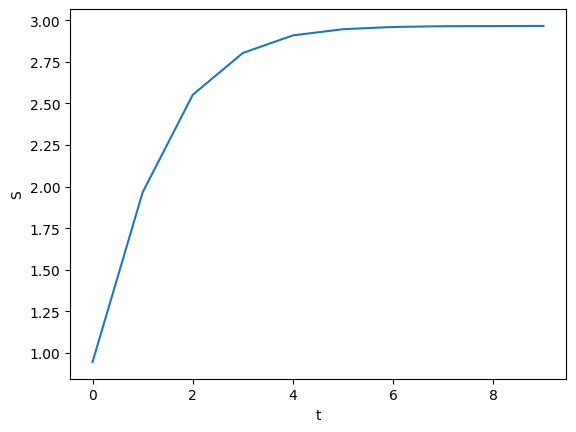

In [42]:
dynamics = [average_ee(10, d + 1) for d in range(10)]
plt.plot(dynamics)
plt.xlabel("t")
plt.ylabel("S")